# Reinforcement learning intro and first policies

In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.neural_network import MLPClassifier

from IPython.display import clear_output

### Environment

In [182]:
env = gym.make("CartPole-v0").env

### States (observations of environment)

In [3]:
s = env.reset()
s

array([ 0.03606813,  0.00465104,  0.04798672,  0.00245485])

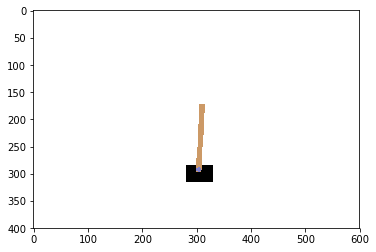

In [4]:
plt.imshow(env.render("rgb_array"))
# kill popup window
env.close()

### Actions (on environment)

In [5]:
env.action_space

Discrete(2)

In [6]:
# possible actions
[env.action_space.sample() for _ in range(10)]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1]

__Take a step, extract new state and reward__

In [9]:
# leaning right, lets accelerate right
s, r, done, info = env.step(action=1)
print(r, done, info)

1.0 False {}


### Policies

A function that receives the current state, and returns an action. Here is the __intelligence__.

In [104]:
def basic_policy(obs):
    # simple rule: if inclinated right, accelerate right
    if obs[2] > 0:
        return 1
    else:
        return 0

### Play the game

In [374]:
def play(env, policy_function, t_max=1000, policy_function_kws={}, render=False, freeze_time_steps=0):
    """
    Play a game with a given policy_function, save interactions
    """
    states, actions = [], []
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        # given state, take action
        a = policy_function(s, **policy_function_kws)
        states.append(s)
        actions.append(a)
        
        # take step
        s, r, done, info = env.step(a)
        total_reward += r
        
        if render:
            env.render()
            if freeze_time_steps != 0:
                time.sleep(freeze_time_steps)                
        if done: 
            break
    
    if render:
        print(f'Reward: {total_reward}')
    
    return states, actions, total_reward

In [377]:
states, actions, reward = play(env, basic_policy, render=True)

Reward: 52.0


In [169]:
env.close()

Now we have seen how  
__AGENT__       interacts with an  
__ENVIRONMENT__ by observing  
__STATES__      and takes  
__ACTIONS__ 	according to a  
__POLICY__  	    
In return it receives  
__REWARDS__

Let's now explore new policies

### MLP Policy

In [383]:
# mlp classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    warm_start=True, # keep progress between .fit(...) calls
    max_iter=1 # make only 1 iteration on each .fit(...)
)

In [384]:
# initialize agent to the dimension of state an amount of actions
n_actions = env.action_space.n
mlp.fit([env.reset()]*n_actions, list(range(n_actions)));

C:\Users\manuel.lopez\AppData\Local\conda\conda\envs\my_root\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Let's add mlp object a new method _policy_ to respond to observations

In [385]:
def mlp_policy(self, state):
    probs = self.predict_proba([state])[0] 
    a = np.random.choice(a=np.array([0,1]), p=probs)
    
    return a

In [386]:
import types

In [387]:
mlp.policy = types.MethodType(mlp_policy, mlp)

In [378]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    
    return discounted_rewards

In [379]:
discount_rewards([1,1,1], 0.7)

array([ 2.19,  1.7 ,  1.  ])

In [391]:
def play2(env, policy_function, discount_rate, t_max=1000, render=False, freeze_time_steps=0):
    """
    Play a game with a given policy_function, save interactions. Sum rewards of future happenings.
    """
    states, actions, rewards = [], [], []
    
    s = env.reset()
    
    for t in range(t_max):
        # register state
        states.append(s)
        
        # given state, compute action to take
        a = policy_function(s)
        
        # register action
        actions.append(a)
        
        # take step
        s, r, done, info = env.step(a)
        
        # register reward
        rewards.append(r)

        if render:
            env.render()
            if freeze_time_steps != 0:
                time.sleep(freeze_time_steps)                
        if done: 
            break
    
    total_reward = sum(rewards)
    
    if render:
        print(f'Reward: {total_reward}')
    
    cum_rewards = discount_rewards(rewards, discount_rate=discount_rate)

    return states, actions, cum_rewards, total_reward

In [392]:
states, actions, rewards, score = play2(env, mlp.policy, 0.8)

### MLP training

In [314]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    Regardless of the particular game
    
    Args:
        states_batch (list of lists): of states, states_batch[session_i][t]
        actions_batch (list of lists): of actions, actions_batch[session_i][t]
        rewards_batch (list of int): of rewards rewards_batch[session_i]
    
    Returns: 
        elite_states (list)
        elite_actions (list)
    """
    reward_threshold = np.percentile(rewards_batch, q=percentile)
    
    elite_states  = list(itertools.chain(*[s for i, s in enumerate(states_batch) if rewards_batch[i] >= reward_threshold]))
    elite_actions = list(itertools.chain(*[a for i,a in enumerate(actions_batch) if rewards_batch[i] >= reward_threshold]))
    
    return elite_states, elite_actions

In [315]:
def show_progress(batch_rewards, log, percentile, reward_range=(0,1000)):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 500.040, threshold=691.300


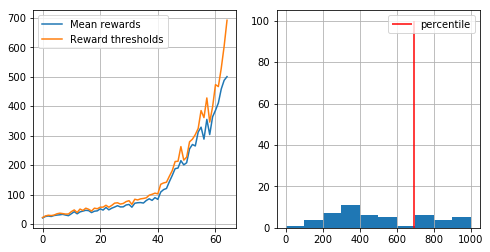

You got over 500 mean steps in the game


In [316]:
# how many games between retraining weights
n_games = 50
# how many times to change the weights
n_epochs = 200

# what percent of games tdo we keep
percentile = 70
log = []

for i in range(n_epochs):
    # play n_games games
    games = [play(env, mlp.policy) for i in range(n_games)]
    
    # record all states, actions, rewards
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*games))

    # keep the ones from most rewarded games
    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile)    
    
    # adjust weights
    mlp.fit(elite_states, elite_actions)

    show_progress(batch_rewards, log, percentile)
    
    if np.mean(batch_rewards) > 500:
        print("You got over 500 mean steps in the game")
        break

(array([  1.,   4.,   7.,  11.,   6.,   5.,   1.,   6.,   4.,   5.]),
 array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.]),
 <a list of 10 Patch objects>)

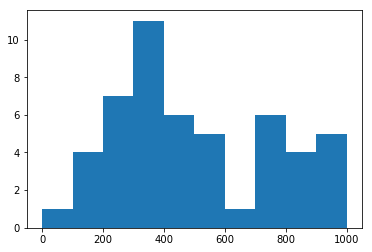

In [317]:
# the last epoch, there were n_games played, the rewards were:
plt.hist(batch_rewards, range=(0,1000))

In [329]:
# lets see it play
states, actions, reward = play(env, mlp.policy, render=True)

Reward: 1000.0


## Guardar aprendizaje en video, con Linux

In [176]:
# record sessions
import gym.wrappers

env = gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True)

env.reset()

games = [play(env, mlp_policy) for _ in range(100)]

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

### Now what?

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

_if you have any trouble with CartPole-v0 and feel stuck, take a look at the forums_

* Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* Bonus quest: Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips & tricks
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__